In [2]:
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import mpl_finance
from plotly import tools, subplots
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
init_notebook_mode(connected=True)

import warnings
warnings.simplefilter('ignore')

In [3]:
df_btc = pd.read_excel('./data/cryptocurrency_history.xlsx', sheet_name='BTC')
df_btc = df_btc.set_index('Date').sort_index()
df_btc.head()

,Open,High,Low,Close,Volume,Total
Date,,,,,,
2017-01-01,112622.71,117229.96,112043.15,116674.24,17270465185,1875811119909
2017-01-02,116628.48,120456.04,116404.83,119330.18,25948985216,1918745803473
2017-01-03,119925.62,122564.55,119925.62,122536.37,21736871520,1970551846356
2017-01-04,122894.55,136428.96,122894.55,135877.08,40589793937,2185351826289
2017-01-05,135013.52,139025.19,106263.87,118281.71,59550428214,1902565739683


- Open:開始価格
- High:最高価格
- Low:最低価格
- Close:終値
- Volume:取引価格
- Total:時価総額

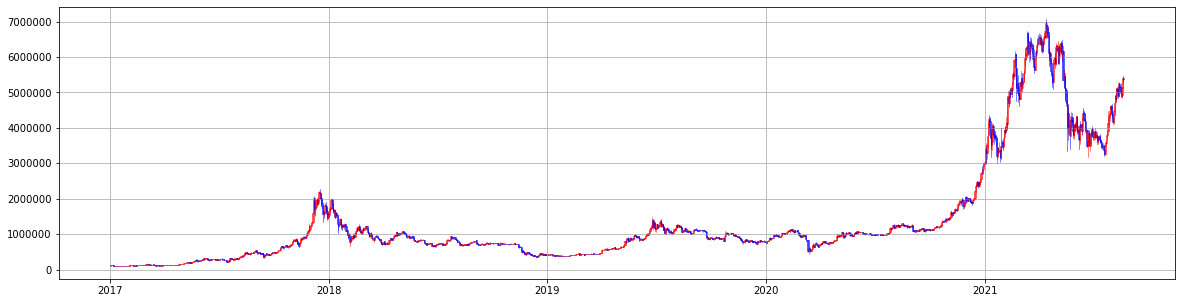

In [4]:
# BTCのチャート可視化
df_btc_ = df_btc[['Open', 'High', 'Low', 'Close', 'Volume']]
df_btc_.index = mdates.date2num(df_btc_.index)
data = df_btc_.reset_index().values

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 1, 1)

mpl_finance.candlestick_ohlc(ax, data, width=2, alpha=0.5, colorup='r', colordown='b')

ax.grid()

locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
plt.show()

ドミナンス
- 総時価総額の占有率

In [5]:
df_dom = pd.read_excel('./data/cryptocurrency_history.xlsx', sheet_name='dominance')
df_dom = df_dom.set_index('Date').sort_index()
df_dom.head()

,BTC,ETH,BCH,LTC,XRP,Others
Date,,,,,,
2017-01-01,0.8732,0.0392,0.0,0.0120,0.0132,0.0624
2017-01-02,0.8761,0.0396,0.0,0.0121,0.0127,0.0593
2017-01-03,0.8763,0.0390,0.0,0.0123,0.0122,0.0603
2017-01-04,0.8698,0.0445,0.0,0.0118,0.0121,0.0618
2017-01-05,0.8714,0.0452,0.0,0.0111,0.0114,0.0609


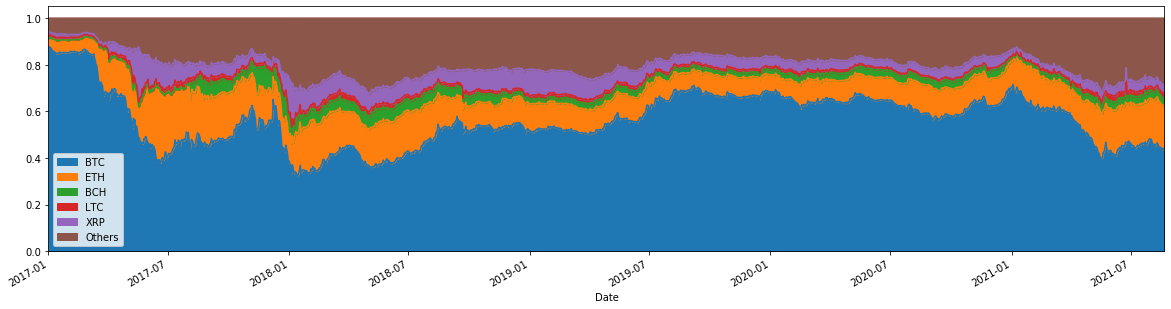

In [6]:
# 各通貨のドミナンスの可視化
fig = df_dom.plot.area(figsize=(20, 5))
plt.show()

In [7]:
df = pd.merge(df_btc, df_dom[['BTC']], left_index=True, right_index=True)
df = df.rename(columns={'BTC':'Dominance'})
df.head()

,Open,High,Low,Close,Volume,Total,Dominance
Date,,,,,,,
2017-01-01,112622.71,117229.96,112043.15,116674.24,17270465185,1875811119909,0.8732
2017-01-02,116628.48,120456.04,116404.83,119330.18,25948985216,1918745803473,0.8761
2017-01-03,119925.62,122564.55,119925.62,122536.37,21736871520,1970551846356,0.8763
2017-01-04,122894.55,136428.96,122894.55,135877.08,40589793937,2185351826289,0.8698
2017-01-05,135013.52,139025.19,106263.87,118281.71,59550428214,1902565739683,0.8714


## 取引の前提条件

- 日次のBitcoinデータを利用する
- 終値の値を、その日のコインの売値/買値とする
- エージェントは日次で「買い」「売り」「保持」のいずれか行動（Action）を選択する
- 1度に買えるコインは、日本円換算で1万円
- 売りを選択した場合、その時に保持している全てのコインを売却する
- 報酬の計算 （現在のBTC価格 - それぞれの買い入れ時のBTC価格） × 保持しているコインの数
- エージェントは、直近30日分のBTC価格の増減値およびBTCのドミナンスをもとに学習する

In [8]:
train_test_split = '2021-01-01'
df_train = df[:train_test_split]
df_test = df[train_test_split:]

In [9]:
print('trainデータの日数: {}'.format(df_train.shape[0]))
print('testデータの日数: {}'.format(df_test.shape[0]))

trainデータの日数: 1453
testデータの日数: 230


In [10]:
# 環境クラス
class Environment:
    def __init__(self, df, term=30):
        self.df = df #コインデータ
        self.budget = 10000
        self.term = term #遡って参照できる期間（day）
        self.reset()

    def reset(self):
        self.num = 0
        self.profits = 0
        self.values = []
        self.history_val = [0 for _ in range(self.term)]
        self.history_dom = [0 for _ in range(self.term)]
        
        #それぞれ３０日間の価格の増減値とドミナンスを結合した60次元のベクトル（初期状態）
        return self.history_val + self.history_dom

    def step(self, act):
        reward = 0
        #buy_count = 0
        #sell_count = 0
        # act　= {0:保持, 1:買い, 2:売り}
        if act == 1:
            self.values.append(self.df.iloc[self.num, :]['Close'])
            #buy_count += 1
        elif act == 2:
            if len(self.values) == 0:
                reward = -1
            else:
                profits = 0

                for value in self.values:
                    profits += self.budget * ((self.df.iloc[self.num, :]['Close']-value)/value)

                reward += profits
                self.profits += profits
                self.values = []
                #sell_count += 1

        self.num += 1
        self.history_val.pop(0)
        self.history_val.append((self.df.iloc[self.num, :]['Close'] - self.df.iloc[(self.num-1), :]['Close']))
        self.history_dom.pop(0)
        self.history_dom.append(self.df.iloc[self.num, :]['Dominance'])

        # 報酬のクリッピング（報酬設定の簡素化：利益:1,損益:-1）
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1

        return self.history_val + self.history_dom, reward

In [11]:
env = Environment(df_train)
for _ in range(3):
    act = np.random.randint(3)
    print(env.step(act)[0][:30])
    print(env.step(act)[0][30:])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2655.939999999988]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8761, 0.8763]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2655.939999999988, 3206.1900000000023, 13340.709999999992]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8761, 0.8763, 0.8698, 0.8714]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2655.939999999988, 3206.1900000000023, 13340.709999999992, -17595.36999999998, -14113.580000000002]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8761, 0.8763, 0.8698, 0.8714, 0.8639, 0.8581]


In [12]:
df_train.head(3)

,Open,High,Low,Close,Volume,Total,Dominance
Date,,,,,,,
2017-01-01,112622.71,117229.96,112043.15,116674.24,17270465185,1875811119909,0.8732
2017-01-02,116628.48,120456.04,116404.83,119330.18,25948985216,1918745803473,0.8761
2017-01-03,119925.62,122564.55,119925.62,122536.37,21736871520,1970551846356,0.8763


## DQN

In [13]:
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)        
        
    def __call__(self, h):
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return h

In [14]:
# 学習パラメータ
epoch_num = 300
step_max = len(env.df)-1
total_step = 0
memory_size = 200
batch_size = 20
gamma = 0.95 #割引率
train_freq = 50 #Q関数の学習間隔

# ε-Greedy法パラメータ
epsilon = 1.0
epsilon_decrease = 0.0001
epsilon_min = 0.1
start_reduce_epsilon = 500

# ログパラメータ
update_q_freq = 50
show_log_freq = 1

In [ ]:
Q = DQN(input_size=env.term*2, hidden_size=100, output_size=3)
Q_ = copy.deepcopy(Q)
optimizer = optim.RMSprop(Q.parameters(), lr=0.0001, alpha=0.95, eps=0.01)

memory = []
total_rewards = []
total_losses = []

for epoch in range(epoch_num):
    init_hist = env.reset()
    step = 0

    total_reward = 0
    total_loss = 0
    while step < step_max:
        act = np.random.randint(3)

        if np.random.rand() > epsilon:
            init_hist_ = np.array(init_hist, dtype="float32").reshape((1, -1))
            init_hist_ = Variable(torch.from_numpy(init_hist_))
            act = Q(init_hist_)
            maxs, indices = torch.max(act.data, 1)
            act = indices.numpy()[0]

        # experience replay
        hist, reward  = env.step(act)
        memory.append((init_hist, act, reward, hist))
        if len(memory) > memory_size:
            memory.pop(0)

        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))

                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    ba_init_hist = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    ba_act = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    ba_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    ba_hist = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)

                    ba_init_hist_ = Variable(torch.from_numpy(ba_init_hist))
                    q = Q(ba_init_hist_)
                    ba_hist_ = Variable(torch.from_numpy(ba_hist))
                    maxs, indices = torch.max(Q_(ba_hist_).data, 1)
                    maxq = maxs.numpy()
                    target = copy.deepcopy(q.data.numpy())
                    for j in range(batch_size):
                        target[j, ba_act[j]] = ba_reward[j] + gamma * maxq[j]

                    loss = nn.MSELoss()(q, Variable(torch.from_numpy(target)))
                    total_loss += loss.item()
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            if total_step % update_q_freq == 0:
                Q_ = copy.deepcopy(Q)

        # e-greedy policy
        if epsilon > epsilon_min and total_step > start_reduce_epsilon:
            epsilon -= epsilon_decrease

        # next step
        total_reward += reward
        init_hist = hist
        step += 1
        total_step += 1

    total_rewards.append(total_reward)
    total_losses.append(total_loss)
    if (epoch+1) % show_log_freq == 0:
        log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
        log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
        print('\t'.join(map(str, ['epoch:{} epsilon:{} reward:{} loss:{}'.format(epoch+1, epsilon, log_reward, log_loss)])))

epoch:10 epsilon:0.09990000000009565 reward:-74.1 loss:17.17875652459916
epoch:20 epsilon:0.09990000000009565 reward:36.1 loss:5.321751915104687
epoch:30 epsilon:0.09990000000009565 reward:54.5 loss:5.123987169377505
epoch:40 epsilon:0.09990000000009565 reward:73.2 loss:5.154394747829064
epoch:50 epsilon:0.09990000000009565 reward:66.1 loss:5.198789747478441
epoch:60 epsilon:0.09990000000009565 reward:75.7 loss:4.940910839242861
epoch:70 epsilon:0.09990000000009565 reward:78.3 loss:5.21744686672464
epoch:80 epsilon:0.09990000000009565 reward:81.4 loss:5.252479320531711
epoch:90 epsilon:0.09990000000009565 reward:91.0 loss:5.054997301241383
epoch:100 epsilon:0.09990000000009565 reward:88.3 loss:5.367097438313067
epoch:110 epsilon:0.09990000000009565 reward:91.5 loss:5.460484903864563
epoch:120 epsilon:0.09990000000009565 reward:108.7 loss:5.677574009541422
epoch:130 epsilon:0.09990000000009565 reward:96.7 loss:5.552730654925108
epoch:140 epsilon:0.09990000000009565 reward:99.4 loss:5.16

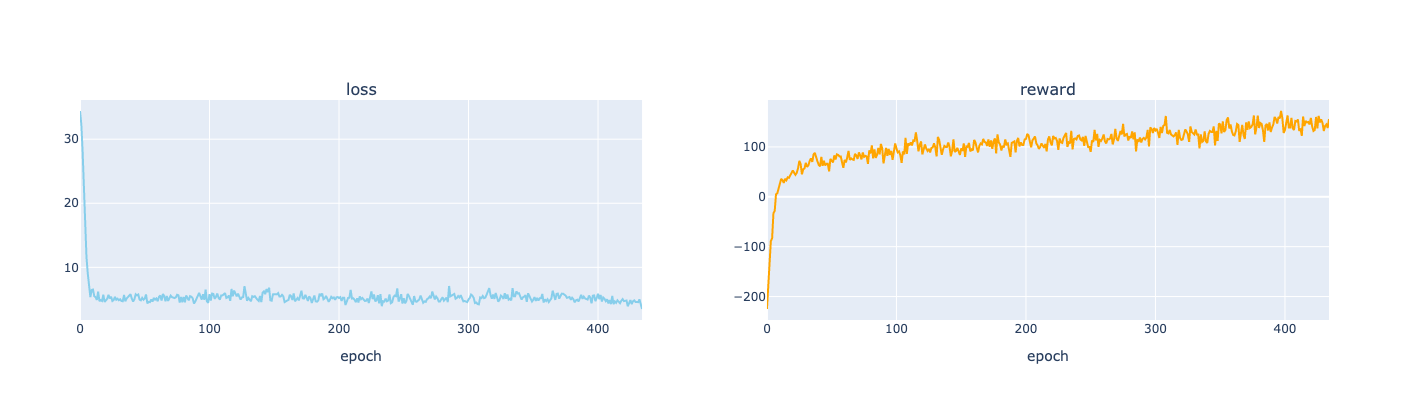

In [170]:
figure = subplots.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
figure['layout']['xaxis1'].update(title='epoch')
figure['layout']['xaxis2'].update(title='epoch')
figure['layout'].update(height=400, width=900, showlegend=False)
iplot(figure)

In [171]:
train_env = Environment(df_train)
test_env = Environment(df_test)

In [172]:
init_hist = train_env.reset()

train_acts = []
train_rewards = []
for _ in range(len(train_env.df)-1):
    act = Q(Variable(torch.from_numpy(np.array(init_hist, dtype=np.float32).reshape(1, -1))))
    act = np.argmax(act.data)
    train_acts.append(act)
    hist, reward = train_env.step(act)
    train_rewards.append(reward)
    init_hist = hist

train_profits = train_env.profits

# test
init_hist = test_env.reset()
test_acts = []
test_rewards = []
for _ in range(len(test_env.df)-1):
    act = Q(Variable(torch.from_numpy(np.array(init_hist, dtype=np.float32).reshape(1, -1))))
    act = np.argmax(act.data)
    test_acts.append(act)
    hist, reward = test_env.step(act)
    test_rewards.append(reward)
    init_hist = hist

test_profits = test_env.profits

# plot
train_copy = train_env.df.copy()
test_copy = test_env.df.copy()
train_copy['act'] = train_acts + [np.nan]
train_copy['reward'] = train_rewards + [np.nan]
test_copy['act'] = test_acts + [np.nan]
test_copy['reward'] = test_rewards + [np.nan]

train0 = train_copy[train_copy['act'] == 0]
train1 = train_copy[train_copy['act'] == 1]
train2 = train_copy[train_copy['act'] == 2]

test0 = test_copy[test_copy['act'] == 0]
test1 = test_copy[test_copy['act'] == 1]
test2 = test_copy[test_copy['act'] == 2]

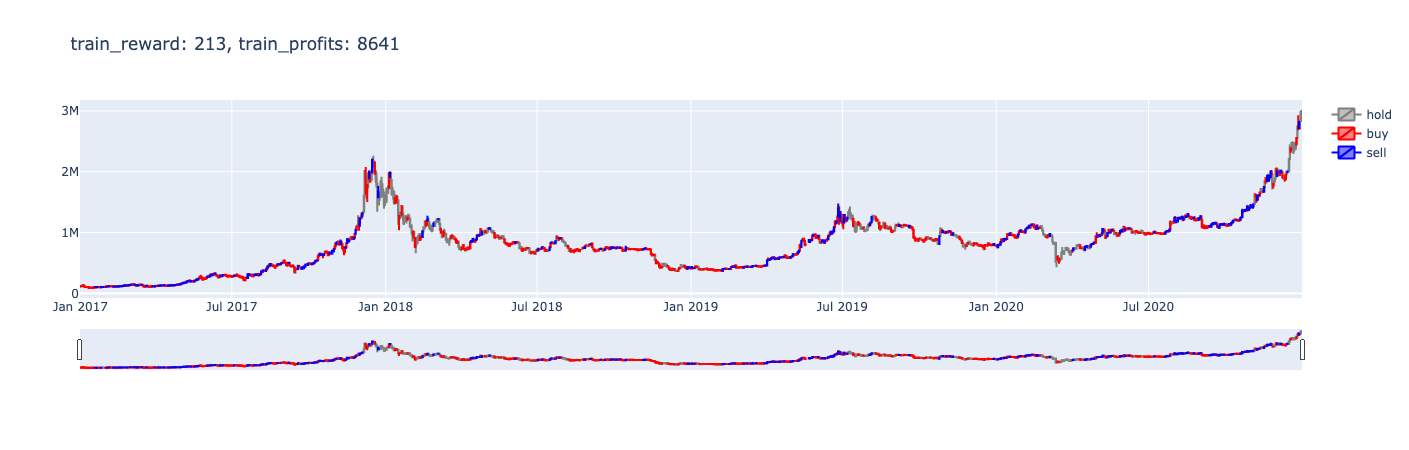

In [173]:
act_color0, act_color1, act_color2 = 'gray', 'red', 'blue'
data = [
    Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0)), name='hold'),
    Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1)), name='buy'),
    Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)), name='sell')
]

layout = {
    'title': 'train_reward: {}, train_profits: {}'.format(
    int(sum(train_rewards)),
    int(train_profits)
    )
}

figure = Figure(data=data, layout=layout)
iplot(figure)

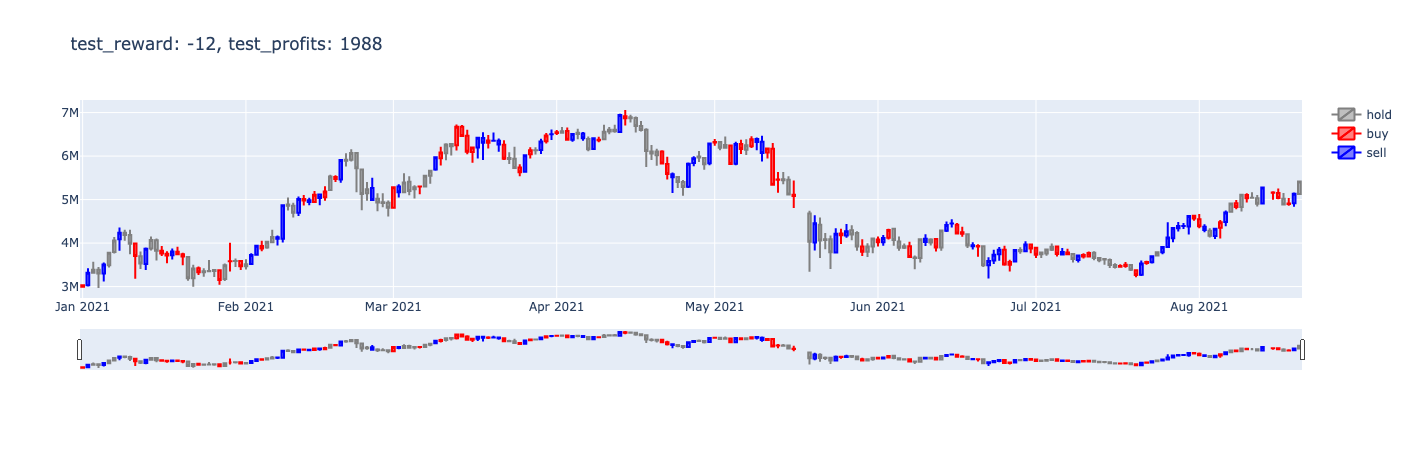

In [174]:
data = [
    Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0)), name='hold'),
    Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1)), name='buy'),
    Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)), name='sell')
]

layout = {
    'title': 'test_reward: {}, test_profits: {}'.format(
    int(sum(test_rewards)),
    int(test_profits)
    )
}

figure = Figure(data=data, layout=layout)
iplot(figure)